# Multithreading in Python(Set)

스레드는 **스레드 제어 블록(TCB)**에 모든 정보를 포함한다.

- 스레드 식별자: 고유한 ID(TID)가 모든 새 스레드에 할당된다.
- 스택 포인터: 프로세스에서 스레드의 스택을 가리킨다. 스택에는 스레드 범위에서 로컨 변수가 포함된다.
- 프로그램 카운터: 스레드에 의해 현재 실행중인 명령의 주소를 저장하는 레지스터
- 스레트 상태: 실행중, 준비중, 대기중, 시작 또는 완료
- 스레드 레지스터 세트: 계산을 위해 스레드에 할당 된 레지스터
- 상위 프로세스 포인터: 스레드가 상주하는 프로세스의 프로세스 제어 블록(PCB)에 대한 포인터

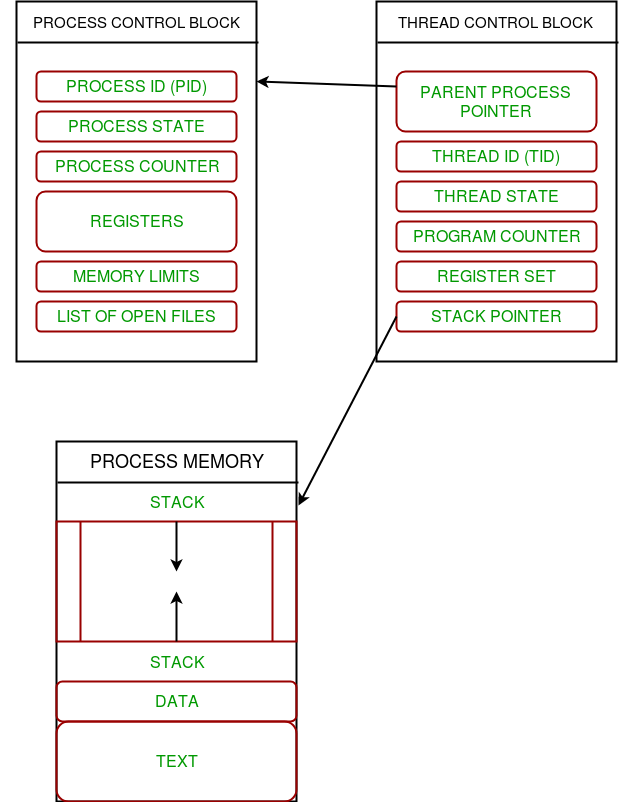

## 멀티 스레딩

하나의 프로세스 내에 여러 스레드가 존재할 수 있다.

- 각 스레드에는 자체 **레지스터 세트**와 **로컬 변수(스택에 저장됨)**가 있다.
- 프로세스의 모든 스레드는 **전역 변수(힙에 저장됨)**와 **프로그램 코드**를 공유한다.

![image.png](https://media.geeksforgeeks.org/wp-content/uploads/multithreading-python-21.png)

프로세스에 두 개의 활성 스레드가 포함된 다이어그램

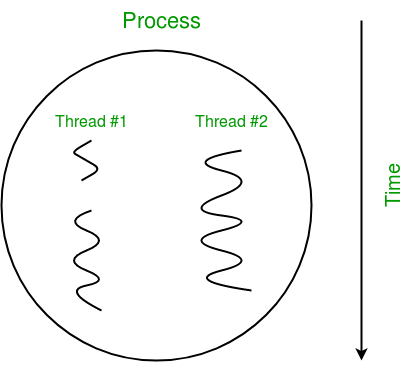

## 파이썬에서 멀티 스레딩

In [8]:
import threading

def print_cube(num):
    print(f'Cube: {num*num*num}')
    
def print_square(num):
    print(f'Square: {num * num}')
    
t1 = threading.Thread(target=print_square, args=(10,))
t2 = threading.Thread(target=print_cube, args=(10,))

t1.start()
t2.start()

t1.join()
t2.join()

print('Done!')

Square: 100
Cube: 1000
Done!


위 프로그램의 작동 방식 다이어그램

![image.png](https://media.geeksforgeeks.org/wp-content/uploads/multithreading-python-4.png)

In [10]:
import threading
import os

def task1():
    print(f'Task 1 assigned to thread: {threading.current_thread()}')
    print(f'ID of process running task 1: {os.getpid()}')
    
def task2():
    print(f'Task 2 assigned to thread: {threading.current_thread()}')
    print(f'ID of process running task 1: {os.getpid()}')
    
print(f'ID of process running main program: {os.getpid()}')
print(f'Main thread name: {threading.main_thread().name}')

t1 = threading.Thread(target=task1, name='t1')
t2 = threading.Thread(target=task2, name='t2')

t1.start()
t2.start()

t1.join()
t2.join()

ID of process running main program: 1676
Main thread name: MainThread
Task 1 assigned to thread: <Thread(t1, started 123145477513216)>
ID of process running task 1: 1676
Task 2 assigned to thread: <Thread(t2, started 123145482768384)>
ID of process running task 1: 1676


- threading.main_thread()를 사용하여 메인 스레드 객체를 얻는다.
 - 주 스레드는 Python 인터프리터가 시작된 스레드이다.
 
- threading.current_thread()는 현재 thread 객체를 얻는다.

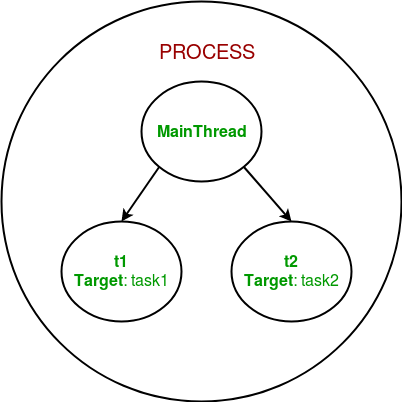

# Multithreading in Python(Synchronization)

### 스레드 간 동기화

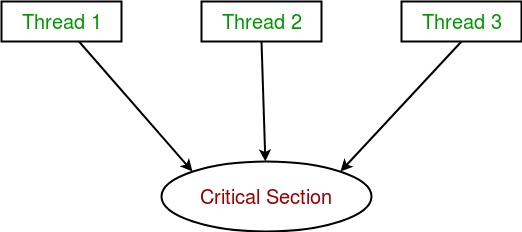

공유 리소스에 대한 동시 엑세스는 경쟁 조건으로 이어질 수 있다.  

경쟁 조건은 둘 이상의 스레드가 공유 데이터에 액세스 할 수 있고, 동시에 변경하려고 할 때 발생한다. 결과적으로 변수의 값은 예측할 수 없으며, 프로세스의 컨텍스트 스위치 타이밍에 따라 달라질 수 있다.

In [1]:
import threading

x = 0 # global var

def increment():
    global x
    x += 1
    
def thread_task():
    for _ in range(100000):
        increment()
        
def main_task():
    global x
    x = 0
    
    t1 = threading.Thread(target=thread_task)
    t2 = threading.Thread(target=thread_task)
    
    t1.start()
    t2.start()
    
    t1.join()
    t2.join()
    
for i in range(10):
    main_task()
    print(f'Iteration {i}: x = {x}')

Iteration 0: x = 184782
Iteration 1: x = 200000
Iteration 2: x = 195851
Iteration 3: x = 200000
Iteration 4: x = 186973
Iteration 5: x = 200000
Iteration 6: x = 100000
Iteration 7: x = 167844
Iteration 8: x = 200000
Iteration 9: x = 200000


- `main_task`에서 두 개의 스레드 t1, t2가 작성되고 전역 변수 x가 0으로 설정
- 각 스레드에는 `thread_task`함수가 있으며 `increment()`가 100000회 호출된다.
- `increment()`는 각 호출에서 전역 변수 x를 1씩 증가시킨다.

x의 최종 예상 값은 200000이지만, `main_task`의 10회 반복에서 얻는 것은 다른 값이다. 공유 변수 x에 대한 스레드의 동시 엑세스로 인한 결과이다. x는 경쟁 조건일 뿐이기 때문이다.
  
경쟁 조건이 어떻게 발생하는지에 대한 다이어그램이다.

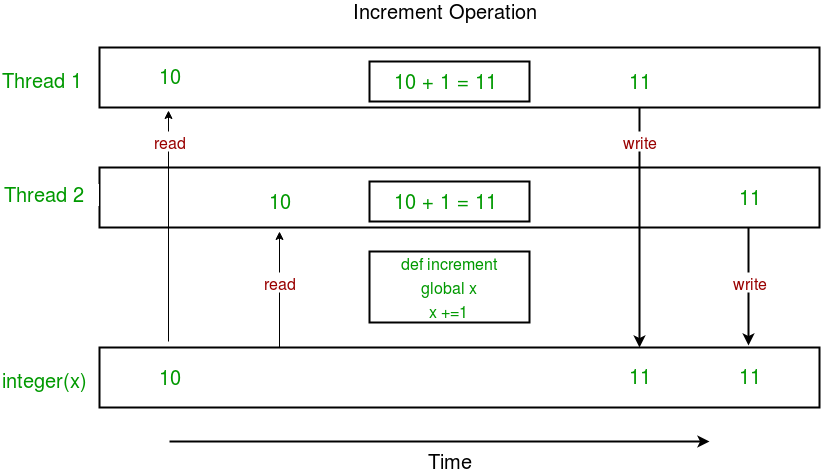

위 다이어그램에서의 x 예상 값은 12이지만 경쟁 조건으로 인해 11이 된다.  

따라서 여러 스레드 간의 동기화를 위한 도구가 필요하다.

### Using Lock

스레딩 모듈은 경쟁 조건을 처리하기 위해 Lock 클래스를 제공한다. Lock은 OS에서 제공하는 세마포어 객체를 사용하여 구현된다.

#### Class Lock

- `acquire([blocking])`: 잠금을 획득한다. 잠금이 차단되거나 차단되지 않을 수 있다.
 - blocking 인수를 True(기본값)로 설정하여 호출하면 잠금이 해제 될 때까지 스레드 실행이 차단 된 다음 lock이 잠금으로 설정되고 True를 리턴한다.
 - blocking 인수를 False로 설정하여 호출하면 스레드 실행이 차단되지 않는다. 잠금이 잠금 해제된 경우 잠금으로 설정하고 True를 리턴하고, 그렇지 않으면 False를 즉시 리턴한다.
- `release()`: 잠금을 해제한다.
 - 잠겨있으면 잠금을 해제로 재설정한다. 잠금이 해제 될 때까지 다른 스레드가 차단 된 경우 정확히 하나의 스레드가 진행되도록 한다.
 - 이미 해제 되어 있으면 **ThreadError**가 발생한다.

In [3]:
import threading

x = 0

def increment():
    global x
    x += 1
    
def thread_task(lock):
    for _ in range(100000):
        lock.acquire()
        increment()
        lock.release()
        
def main_task():
    global x
    x = 0
    
    # Lock 객체 생성
    lock = threading.Lock()
    
    # Lock 객체를 함수 인수로 전달
    t1 = threading.Thread(target=thread_task, args=(lock,))
    t2 = threading.Thread(target=thread_task, args=(lock,))
    
    t1.start()
    t2.start()
    
    t1.join()
    t2.join()
    
for i in range(10):
    main_task()
    print(f'Iteration {i}: x = {x}')

Iteration 0: x = 200000
Iteration 1: x = 200000
Iteration 2: x = 200000
Iteration 3: x = 200000
Iteration 4: x = 200000
Iteration 5: x = 200000
Iteration 6: x = 200000
Iteration 7: x = 200000
Iteration 8: x = 200000
Iteration 9: x = 200000


위 프로그램에서 잠금 구혀을 나타내는 다이어그램  

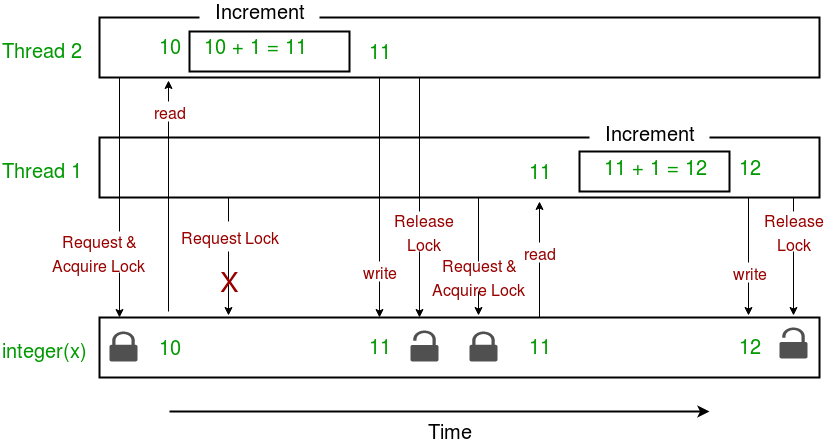

### 멀티 스레딩의 장,단점

#### 장점

- 사용자를 차단하지 않는다. 스레드가 서로 독립적이기 때문.
- 스레드가 작업을 병렬로 실행하기 때문에 시스템 리소스를 보다 효율적으로 사용할 수 있다.
- 다중 프로세스 시스템의 성능이 향상
- 멀티 스레드 서버 및 대화식 GUI는 멀티 스레딩을 독점적으로 사용

#### 단점

- 스레드 수가 증가하면 복잡성이 증가
- 공유 리소스(객체, 데이터)의 동기화가 필요
- 디버깅이 어렵고, 결과를 예측할 수 없는 경우가 있다.
- 기아로 이어질 수 있는 잠재적 교착 상태(잘못된 디자인은 일부 스레드를 기아 상태로 만듬)
- 스레드 구성 및 동기화는 CPU/메모리를 많이 사용한다.